# Simple CNN 

In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import random

#### Utilitiy Functions - Dataset Loader Function and other functions

In [2]:
def load_data_from_directory(base_path, img_size=32, test_size=0.2):
    images = []
    labels = []
    num_classes = 43
    for class_idx in range(num_classes):
        class_dir = os.path.join(base_path, str(class_idx))
        if not os.path.exists(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(class_idx)
    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels)
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    return train_test_split(images, labels, test_size=test_size, random_state=42)

def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1.0 - np.tanh(x)**2
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
def cross_entropy(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

#### Plotting the results

In [3]:
def plot_curves(train_acc, val_acc, train_loss, val_loss, title=''):
    epochs = np.arange(1, len(train_acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Simple CNN Model

In [7]:
class SimpleCNN:
    def __init__(self, input_shape=(32,32,3), num_filters=16, filter_size=3, hidden_size=256, output_size=43, learning_rate=0.001):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size, 3) * 0.01
        self.conv_bias = np.zeros(num_filters)
        self.fc1 = np.random.randn(num_filters * (32-filter_size+1)**2, hidden_size) * 0.01
        self.b1 = np.zeros(hidden_size)
        self.fc2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros(output_size)
        self.m = {'fc1':0, 'b1':0, 'fc2':0, 'b2':0}
        self.v = {'fc1':0, 'b1':0, 'fc2':0, 'b2':0}
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.t = 0
        self.lr = learning_rate

    def conv_forward(self, X):
        batch, H, W, C = X.shape
        F, f, _, _ = self.filters.shape
        out = np.zeros((batch, H-f+1, W-f+1, F))
        for i in range(H-f+1):
            for j in range(W-f+1):
                patch = X[:, i:i+f, j:j+f, :]
                out[:,i,j,:] = np.tensordot(patch, self.filters, axes=([1,2,3],[1,2,3])) + self.conv_bias
        return tanh(out)

    def forward(self, X):
        self.conv_out = self.conv_forward(X)
        batch = X.shape[0]
        self.flat = self.conv_out.reshape(batch, -1)
        self.z1 = self.flat @ self.fc1 + self.b1
        self.a1 = tanh(self.z1)
        self.z2 = self.a1 @ self.fc2 + self.b2
        return softmax(self.z2)

    def backward(self, X, y_true):
        m = X.shape[0]
        self.t += 1
        y_pred = self.forward(X)
        delta2 = (y_pred - y_true) / m
        grad_fc2 = self.a1.T @ delta2
        grad_b2 = delta2.sum(axis=0)
        delta1 = delta2 @ self.fc2.T * tanh_derivative(self.z1)
        grad_fc1 = self.flat.T @ delta1
        grad_b1 = delta1.sum(axis=0)
        for param, grad in zip(['fc1', 'b1', 'fc2', 'b2'], [grad_fc1, grad_b1, grad_fc2, grad_b2]):
            self.m[param] = self.beta1 * self.m[param] + (1 - self.beta1) * grad
            self.v[param] = self.beta2 * self.v[param] + (1 - self.beta2) * (grad**2)
            m_hat = self.m[param] / (1 - self.beta1**self.t)
            v_hat = self.v[param] / (1 - self.beta2**self.t)
            current_value = getattr(self, param)
            updated_value = current_value - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            setattr(self, param, updated_value)

    

#### Training the model

In [4]:
def train(self, X_train, y_train, X_val, y_val, epochs=8, batch_size=64):
        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.backward(X_batch, y_batch)
            train_pred = self.forward(X_train)
            val_pred = self.forward(X_val)
            train_acc = accuracy(y_train, train_pred)
            val_acc = accuracy(y_val, val_pred)
            train_loss = cross_entropy(y_train, train_pred)
            val_loss = cross_entropy(y_val, val_pred)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        return train_accs, val_accs, train_losses, val_losses

####  Random Search for Hyperparameter Tuning

In [6]:
def random_search_cnn(X_train, y_train, X_val, y_val, n_trials=4):
    param_grid = [
        {'lr': 0.001, 'batch_size': 64, 'num_filters': 16, 'hidden_size': 256},
        {'lr': 0.001, 'batch_size': 32, 'num_filters': 16, 'hidden_size': 128},
        {'lr': 0.005, 'batch_size': 64, 'num_filters': 8,  'hidden_size': 256},
        {'lr': 0.005, 'batch_size': 32, 'num_filters': 8,  'hidden_size': 128},
    ]
    best_val_acc = 0
    best_histories = None
    for params in random.sample(param_grid, n_trials):
        print(f"\nTrial CNN: {params}")
        model = SimpleCNN(num_filters=params['num_filters'], hidden_size=params['hidden_size'], learning_rate=params['lr'])
        train_accs, val_accs, train_losses, val_losses = model.train(X_train, y_train, X_val, y_val, epochs=8, batch_size=params['batch_size'])
        if max(val_accs) > best_val_acc:
            best_val_acc = max(val_accs)
            best_histories = (train_accs, val_accs, train_losses, val_losses)
    print(f"\nBest CNN Val Acc: {best_val_acc:.4f}")
    return best_histories

#### Main Code


Random Search SimpleCNN:

Trial CNN: {'lr': 0.005, 'batch_size': 64, 'num_filters': 8, 'hidden_size': 256}
Epoch 1/8 | Train Loss: 0.6736 | Val Loss: 0.7295 | Train Acc: 0.7948 | Val Acc: 0.7802
Epoch 2/8 | Train Loss: 0.4646 | Val Loss: 0.5376 | Train Acc: 0.8607 | Val Acc: 0.8476
Epoch 3/8 | Train Loss: 0.3602 | Val Loss: 0.4339 | Train Acc: 0.8887 | Val Acc: 0.8669
Epoch 4/8 | Train Loss: 0.3773 | Val Loss: 0.4413 | Train Acc: 0.8811 | Val Acc: 0.8659
Epoch 5/8 | Train Loss: 0.2267 | Val Loss: 0.3000 | Train Acc: 0.9353 | Val Acc: 0.9190
Epoch 6/8 | Train Loss: 0.2717 | Val Loss: 0.3434 | Train Acc: 0.9155 | Val Acc: 0.9013
Epoch 7/8 | Train Loss: 0.1895 | Val Loss: 0.2742 | Train Acc: 0.9395 | Val Acc: 0.9193
Epoch 8/8 | Train Loss: 0.2291 | Val Loss: 0.3145 | Train Acc: 0.9342 | Val Acc: 0.9185

Trial CNN: {'lr': 0.005, 'batch_size': 32, 'num_filters': 8, 'hidden_size': 128}
Epoch 1/8 | Train Loss: 0.4295 | Val Loss: 0.4731 | Train Acc: 0.8858 | Val Acc: 0.8757
Epoch 2/8 | Train 

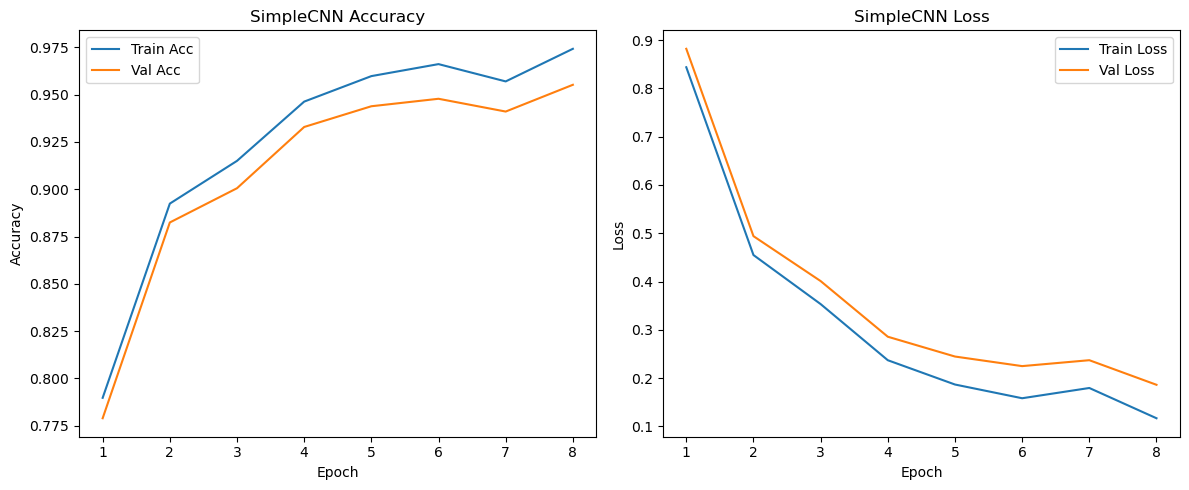

In [1]:
if __name__ == "__main__":
    X_train, X_val, y_train, y_val = load_data_from_directory(
        "/Users/pavankoushik/Development/University/Neural Networks/Dataset/Train"
    )
    print("\nRandom Search SimpleCNN:")
    cnn_histories = random_search_cnn(X_train, y_train, X_val, y_val, n_trials=4)
    plot_curves(*cnn_histories, title="SimpleCNN")
